In [31]:
import os

print(os.getcwd())

/home/wjstjrals417/Dacon/New_drug_development/Seokmin/src/Deepchem


In [32]:
from os.path import join
train_path = join('..', '..', '..', 'data', 'total_data', 'train.csv')
test_path = join('..', '..', '..', 'data', 'total_data', 'test.csv')
submission_path = join('..', '..', '..', 'data', 'total_data', 'sample_submission.csv')

In [33]:
import pandas as pd

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission_data = pd.read_csv(submission_path)

In [34]:
train_data.isnull().sum()

Molecule ChEMBL ID    0
Standard Type         0
Standard Relation     0
Standard Value        0
Standard Units        0
pChEMBL Value         0
Assay ChEMBL ID       0
Target ChEMBL ID      0
Target Name           0
Target Organism       0
Target Type           0
Document ChEMBL ID    0
IC50_nM               0
pIC50                 0
Smiles                0
dtype: int64

In [35]:
train_data.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1947    False
1948    False
1949    False
1950    False
1951    False
Length: 1952, dtype: bool

In [36]:
len(train_data)

1952

In [37]:
len(test_data)

113

In [38]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_data, test_size = 0.2, random_state= 42)

In [39]:
len(train_data)

1561

In [40]:
len(val_data)

391

## Molecular FingerPrint 생성

In [41]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

fps_train = []

for idx, smiles in enumerate(train_data['Smiles']):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)

    fps_train.append(arr)

train_data["fp"] = fps_train

In [42]:
fps_val = []

for idx, smiles in enumerate(val_data['Smiles']):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)

    fps_val.append(arr)

val_data["fp"] = fps_val

In [43]:
fps_test = []

for idx, smiles in enumerate(test_data['Smiles']):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)

    fps_test.append(arr)

test_data["fp"] = fps_test

In [44]:
from torch.utils.data import Dataset

class LipoDataset(Dataset):

    def __init__(self, df):
        self.x = list(df["fp"])
        self.y =list(df["IC50_nM"].values)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return torch.tensor(self.x[index]).float(), torch.tensor(self.y[index]).float()

In [45]:
lipodata = {
    "train" : LipoDataset(train_data),
    "val" : LipoDataset(val_data),
}

## MLP

In [46]:
import torch.nn as nn

class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(2048, 1024) # 완전 연결된 단순 레이어 만들기 
        self.linear2 = nn.Linear(1024, 256)
        self.output = nn.Linear(256, 1) # 최종 예측을 위해 출력 부 크기 1로 설정 
        self.dropout1 = nn.Dropout(0.5) #일반화를 위한 Dropout
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.output(out)
        return out
        
model = MLP()
model

MLP(
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [47]:
from torch.utils.data import DataLoader

dataloaders = {
    "train": DataLoader(lipodata["train"], batch_size=32, shuffle=True),
    "val": DataLoader(lipodata["val"], batch_size=32, shuffle=False)
}

dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fe2a639a130>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fe3aa0aacd0>}

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

# class RMSELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()
        
#     def forward(self, yhat, y):
#         return torch.sqrt(self.mse(yhat, y))

# loss_fn = RMSELoss()  # RMSE 손실 함수 사용
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# print("RMSE 손실 함수와 Adam 옵티마이저가 설정되었습니다.")

In [49]:
import torch

torch.manual_seed(42)

epochs = 51
train_losses = []
val_losses = []


for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for i, data in enumerate(dataloaders["train"]):
        x, y = data[0], data[1]
        optimizer.zero_grad()

        outputs = model(x)
        train_loss = loss_fn(outputs, y.view(-1, 1))
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for i, data in enumerate(dataloaders["val"]):
            x, y = data[0], data[1]
                        
            outputs = model(x)
            val_loss = loss_fn(outputs, y.view(-1, 1))
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(dataloaders["train"])
    epoch_val_loss /= len(dataloaders["val"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if epoch % 10 == 0:
        print("[Epoch %d] Train Loss: %.3f  Validation Loss: %.3f" %
              (epoch, epoch_train_loss, epoch_val_loss))

[Epoch 0] Train Loss: 7408251.177  Validation Loss: 3666056.082
[Epoch 10] Train Loss: 414344.177  Validation Loss: 4153951.611
[Epoch 20] Train Loss: 339491.901  Validation Loss: 3922230.480
[Epoch 30] Train Loss: 439165.457  Validation Loss: 4252741.948
[Epoch 40] Train Loss: 276285.022  Validation Loss: 4063573.399
[Epoch 50] Train Loss: 206083.718  Validation Loss: 3905116.696


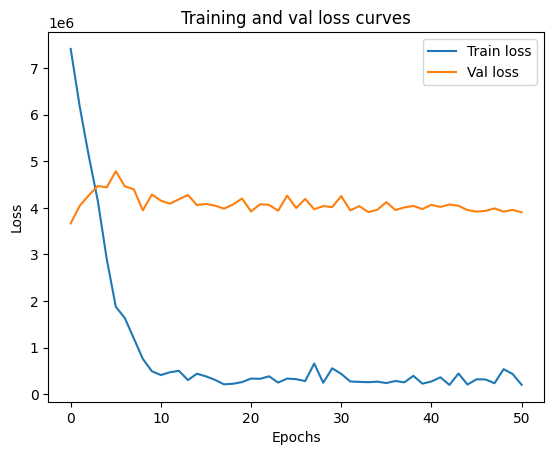

In [50]:
import matplotlib.pyplot as plt

epoch_count = range(epochs)
plt.plot(epoch_count, train_losses, label="Train loss")
plt.plot(epoch_count, val_losses, label="Val loss")
plt.title("Training and val loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Test 예측

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

# LipoDataset 클래스를 테스트 데이터용으로 수정
class TestLipoDataset(Dataset):
    def __init__(self, df):
        self.x = list(df["fp"])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return torch.tensor(self.x[index]).float()

# 테스트 데이터셋 생성
test_dataset = TestLipoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델을 평가 모드로 설정
model.eval()

# 예측 결과를 저장할 리스트
predictions = []

# 예측 수행
with torch.no_grad():
    for batch in test_dataloader:
        outputs = model(batch)
        predictions.extend(outputs.numpy().flatten())

# 예측 결과를 test_data에 추가
test_data['Predicted_IC50_nM'] = predictions

In [23]:
submission_data['IC50_nM'] = predictions

In [24]:
submission_data.to_csv('./deepchem_submit_v2.csv', index=False)

In [27]:
import numpy as np

def calculate_score(y_true, y_pred):
    # IC50(nM) to pIC50 변환
    def to_pIC50(IC50):
        return -np.log10(IC50 * 1e-9)
    
    y_true_pIC50 = to_pIC50(y_true)
    y_pred_pIC50 = to_pIC50(y_pred)
    
    # Normalized RMSE 계산
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    normalized_rmse = rmse / (np.max(y_true) - np.min(y_true))
    
    # Correct Ratio 계산
    absolute_errors_pIC50 = np.abs(y_true_pIC50 - y_pred_pIC50)
    correct_ratio = np.mean(absolute_errors_pIC50 <= 0.5)
    
    # 최종 점수 계산
    A = normalized_rmse
    B = correct_ratio
    score = 0.5 * (1 - min(A, 1)) + 0.5 * B
    
    return score, normalized_rmse, correct_ratio

# 사용 예시
y_true = np.array([100, 200, 300, 400, 500])  # 실제 IC50(nM) 값
y_pred = np.array([110, 190, 280, 420, 510])  # 예측된 IC50(nM) 값

final_score, normalized_rmse, correct_ratio = calculate_score(y_true, y_pred)

print(f"Normalized RMSE: {normalized_rmse:.4f}")
print(f"Correct Ratio: {correct_ratio:.4f}")
print(f"Final Score: {final_score:.4f}")

Normalized RMSE: 0.0371
Correct Ratio: 1.0000
Final Score: 0.9815


Validation Results:
Normalized RMSE: 0.0795
Correct Ratio: 0.4834
Final Score: 0.7019


/tmp/ipykernel_504296/3053946332.py:6: RuntimeWarning: invalid value encountered in log10
  return -np.log10(IC50 * 1e-9)


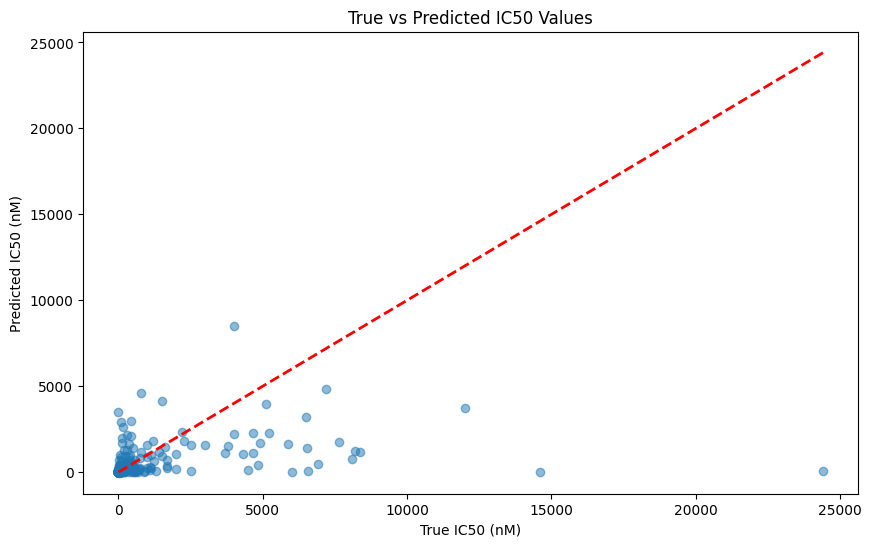

In [51]:
import torch
import numpy as np
from torch.utils.data import DataLoader

# Validation 데이터에 대한 예측 및 점수 계산
def evaluate_model(model, val_data, batch_size=32):
    model.eval()  # 모델을 평가 모드로 설정
    val_dataset = LipoDataset(val_data)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            y_true.extend(targets.numpy())
            y_pred.extend(outputs.squeeze().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    score, normalized_rmse, correct_ratio = calculate_score(y_true, y_pred)
    
    return score, normalized_rmse, correct_ratio, y_true, y_pred

# 모델 평가 실행
score, normalized_rmse, correct_ratio, y_true, y_pred = evaluate_model(model, val_data)

print(f"Validation Results:")
print(f"Normalized RMSE: {normalized_rmse:.4f}")
print(f"Correct Ratio: {correct_ratio:.4f}")
print(f"Final Score: {score:.4f}")

# 추가적인 분석을 위한 scatter plot (선택사항)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
plt.xlabel('True IC50 (nM)')
plt.ylabel('Predicted IC50 (nM)')
plt.title('True vs Predicted IC50 Values')
plt.show()